In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [7]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:15<00:00, 12.52it/s]


In [8]:
print(len(lrv_test))

200


In [9]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [10]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [11]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [12]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [14]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [15]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)


dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)


74836368/74836368 [==============================] - 4s 0us/step


In [16]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(dennet)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 1920)              0         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Dense(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
137/136 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.6876

136/136 [==============================] - 166s 888ms/step - loss: 0.8186 - accuracy: 0.6876 - val_loss: 0.1866 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 2/10
137/136 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8664

136/136 [==============================] - 101s 738ms/step - loss: 0.3596 - accuracy: 0.8664 - val_loss: 0.0834 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 3/10
137/136 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8920

136/136 [==============================] - 100s 732ms/step - loss: 0.2827 - accuracy: 0.8920 - val_loss: 0.0590 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 4/10
137/136 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8924

136/136 [==============================] - 99s 721ms/step - loss: 0.2668 - accuracy: 0.8924 - val_loss: 0.0863 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 5/10
137/136 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9128

136/136 [==============================] - 101s 737ms/step - loss: 0.2263 - accuracy: 0.9128 - val_loss: 0.0500 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 6/10
137/136 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9014

136/136 [==============================] - 101s 741ms/step - loss: 0.2434 - accuracy: 0.9014 - val_loss: 0.0541 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 7/10
137/136 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9144

136/136 [==============================] - 100s 731ms/step - loss: 0.2209 - accuracy: 0.9144 - val_loss: 0.0481 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 8/10
137/136 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9190

136/136 [==============================] - 99s 724ms/step - loss: 0.2169 - accuracy: 0.9190 - val_loss: 0.0677 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 9/10
137/136 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9272

136/136 [==============================] - 100s 732ms/step - loss: 0.1946 - accuracy: 0.9272 - val_loss: 0.0398 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 10/10
137/136 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9252

136/136 [==============================] - 100s 733ms/step - loss: 0.1930 - accuracy: 0.9252 - val_loss: 0.0608 - val_accuracy: 0.9799 - lr: 1.0000e-04


47/47 [==============================] - 17s 281ms/step
Confusion matrix, without normalization
[[205   0   0   1   0   0   0]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  3   0   0 202   0   0   0]
 [  0   0   0   0 190   8   8]
 [  0   0   0   0   8 192   0]
 [  0   0   0   0   6   0 194]]


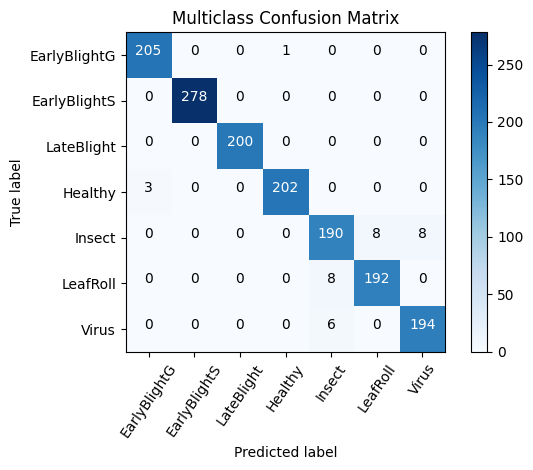

In [19]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

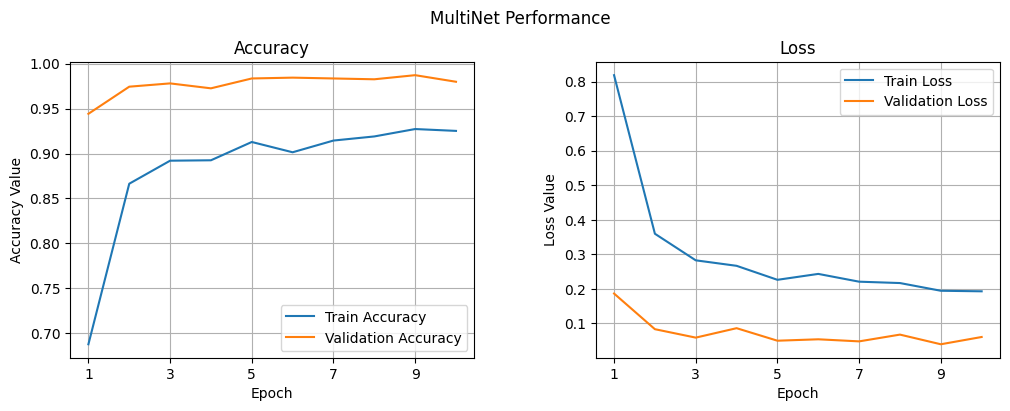

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 11, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 11, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 7s 141ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       0.99      1.00      0.99       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       1.00      1.00      1.00       200
            Healthy       1.00      0.99      0.99       205
             Insect       0.93      0.92      0.93       206
           LeafRoll       0.96      0.96      0.96       200
              Virus       0.96      0.97      0.97       200

           accuracy                           0.98      1495
          macro avg       0.98      0.98      0.98      1495
       weighted avg       0.98      0.98      0.98      1495



In [22]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("DenseNet201")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 7s 143ms/step
DenseNet201
Accuracy: 0.9772575250836121
F1 Score: 0.9772832688607895
precision: 0.9773343808432402
recall: 0.9772575250836121
MSE: 0.07224080267558529
MAE: 0.03745819397993311
